# Custom Parameters

In [1]:
#Assign these values as per your requirements.
global min_qubits,max_qubits,skip_qubits,max_circuits,num_shots,Noise_Inclusion

min_qubits=3
max_qubits=13
max_circuits=3
skip_qubits=1
num_shots=1000
saveplots = False

backend_id = 'default' #['braket_ahs', 'braket_dm', 'braket_sv', 'default'] braket_ahs implementation yet to be done.
Noise_Inclusion = True #only applicable for braket_dm 
Memory_utilization_plot = True
gate_counts_plots = True
Store_Data = True

# Imports:

In [2]:
import numpy as np
from braket.circuits import Circuit,Gate     # AWS imports: Import Braket SDK modules
import time
import matplotlib.pyplot as plt

from braket.devices import LocalSimulator

# saved circuits for display
QC_ = None
Uf_ = None

benchmark_name = "Bernstein-Vazirani"

np.random.seed(0)

# Declaring Backend :

In [3]:
global device

if backend_id == None or backend_id == "":
    device = LocalSimulator() #Statevector Simulator
    device_Name =  device.name
    print(f"Using {device_Name} device for execution")
elif backend_id in LocalSimulator().registered_backends():
    if backend_id in ['braket_dm', 'braket_sv', 'default']:#default -> statevector, sv-> Statevector dm-> density matrix
        device = LocalSimulator(backend=backend_id)
        device_Name = device.name
        print(f"Using {device_Name} device for execution")
    elif backend_id == 'braket_ahs': # ahs -> Analog Hamiltonian Simulation
        device = LocalSimulator(backend=backend_id)
        device_Name = device.name
        print(f"Using {device_Name} device for execution")
        print(f"Implementation for {device_Name} device is yet to be done.")
        device = LocalSimulator(backend='default')
        device_Name = device.name
        print(f"By default executing with {device_Name} backend.")
else:
    print("Enter  a valid Backend")

QV_=None

Using StateVectorSimulator device for execution


# Algorithm :

In [4]:
############### Circuit Definition
def create_oracle(input_size, secret_int):
    qc = Circuit()

    # perform CX for each qubit that matches a bit in secret string
    s = ('{0:0'+str(input_size)+'b}').format(secret_int)
    for i_qubit in range(input_size):
        if s[input_size-1-i_qubit]=='1':
            qc.cnot(i_qubit, input_size)

    #qc = braket_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

    return qc

def BersteinVazirani (num_qubits, secret_int):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1
    
    qc = Circuit()
    
    # put ancilla in superposition
    qc.x(num_qubits-1)
    
    # start with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    Uf = create_oracle(input_size, secret_int)
    qc.add(Uf)

    # end with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    # uncompute ancilla qubit, not necessary for algorithm
    qc.x(input_size)
    
    # save smaller circuit example for display
    global QC_, Uf_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf

    # return a handle on the circuit
    return qc 

# Noise Parameters :

In [5]:
if backend_id == 'braket_dm':
    from braket.circuits import Noise
    
    BitFlipNoise = Noise.BitFlip(probability=0.01)
    DepolarizingNoise = Noise.Depolarizing(probability=0.03)
    PhaseFlipNoise = Noise.PhaseFlip(probability=0.02)
    DephasingNoise2Q = Noise.TwoQubitDephasing(probability=0.01)
    DepolarizingNoise2Q = Noise.TwoQubitDepolarizing(probability=0.01)
    
    noise_parameters = [BitFlipNoise,DepolarizingNoise,PhaseFlipNoise,DephasingNoise2Q,DepolarizingNoise2Q]

# Fidelity Calculations :

In [6]:
## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity

In [7]:
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist

In [8]:
### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity


In [9]:
def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    num_measured_qubits = len(list(correct_dist.keys())[0])
    #print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

### Mathematical formulae:

**hf_fidelity :** 
$$ F_s(P_{ideal},P_{output}) = \biggr[\sum_{x}\sqrt{P_{output}(x)P_{ideal}(x)}\biggr]^2$$

**floor_fidelity :**
$$F_s(P_{ideal},P_{uniform})$$

$$\implies F_{raw}(P_{ideal},P_{output}) = \frac{F_s(P_{ideal},P_{output}) - F_s(P_{ideal},P_{uniform})}{1-F_s(P_{ideal},P_{uniform})}$$

**fidelity (or Normalized or Rescaled fidelity) :**
$$F(P_{ideal},P_{output}) = max\biggr\{F_{raw}(P_{ideal},P_{output}),0\biggr\}$$


### Example:

The equations provided in the paper outline a process for calculating normalized fidelities in the context of quantum computing benchmarks. Here's a detailed explanation of each equation and its significance:

### Equation (1): State Fidelity
$$ F_s (P_{\text{ideal}}, P_{\text{output}}) = \left( \sum_x \sqrt{P_{\text{output}}(x)} \sqrt{P_{\text{ideal}}(x)} \right)^2 $$

This equation calculates the state fidelity, $ F_s $, which measures the similarity between the ideal probability distribution $ P_{\text{ideal}} $ and the output probability distribution $ P_{\text{output}} $. The square root of the product of probabilities for each state $ x $ is summed, and the result is squared to get the fidelity.

### Equation (2): Normalized Fidelity
$$ F(P_{\text{ideal}}, P_{\text{output}}) = \max(F_{\text{raw}}(P_{\text{ideal}}, P_{\text{output}}), 0) $$

This equation defines the normalized fidelity, $ F $, which ensures that the fidelity is non-negative. It takes the raw fidelity $ F_{\text{raw}} $ and applies a max function to ensure the result is at least 0.

### Equation (3): Raw Fidelity
$$ F_{\text{raw}}(P_{\text{ideal}}, P_{\text{output}}) = \frac{F_s (P_{\text{ideal}}, P_{\text{output}}) - F_s (P_{\text{ideal}}, P_{\text{uni}})}{1 - F_s (P_{\text{ideal}}, P_{\text{uni}})} $$

The raw fidelity $ F_{\text{raw}} $ adjusts the state fidelity by comparing it to a uniform distribution $ P_{\text{uni}} $. This adjustment accounts for the baseline performance of random guessing.

- $ P_{\text{uni}} $: A uniform probability distribution where all states are equally probable.

### Explanation with Example

Let's consider a simple example with 2 qubits.

#### 1. State Fidelity Calculation
- **Ideal distribution ($ P_{\text{ideal}} $)**: \{ "00": 0.25, "01": 0.25, "10": 0.25, "11": 0.25 \}
- **Output distribution ($ P_{\text{output}} $)**: \{ "00": 0.5, "01": 0.25, "10": 0.25, "11": 0.0 \}

First, compute $ F_s (P_{\text{ideal}}, P_{\text{output}}) $:
$$ F_s (P_{\text{ideal}}, P_{\text{output}}) = \left( \sqrt{0.5} \cdot \sqrt{0.25} + \sqrt{0.25} \cdot \sqrt{0.25} + \sqrt{0.25} \cdot \sqrt{0.25} + \sqrt{0.0} \cdot \sqrt{0.25} \right)^2 $$
$$ F_s (P_{\text{ideal}}, P_{\text{output}}) = \left( 0.3536 + 0.25 + 0.25 + 0 \right)^2 $$
$$ F_s (P_{\text{ideal}}, P_{\text{output}}) = \left( 0.8536 \right)^2 $$
$$ F_s (P_{\text{ideal}}, P_{\text{output}}) = 0.7286 $$

#### 2. Uniform Distribution Fidelity
- **Uniform distribution ($ P_{\text{uni}} $)**: \{ "00": 0.25, "01": 0.25, "10": 0.25, "11": 0.25 \}

Compute $ F_s (P_{\text{ideal}}, P_{\text{uni}}) $:
$$ F_s (P_{\text{ideal}}, P_{\text{uni}}) = \left( \sqrt{0.25} \cdot \sqrt{0.25} + \sqrt{0.25} \cdot \sqrt{0.25} + \sqrt{0.25} \cdot \sqrt{0.25} + \sqrt{0.25} \cdot \sqrt{0.25} \right)^2 $$
$$ F_s (P_{\text{ideal}}, P_{\text{uni}}) = \left( 0.25 + 0.25 + 0.25 + 0.25 \right)^2 $$
$$ F_s (P_{\text{ideal}}, P_{\text{uni}}) = 1.0 $$

#### 3. Raw Fidelity Calculation
$$ F_{\text{raw}}(P_{\text{ideal}}, P_{\text{output}}) = \frac{0.7286 - 1.0}{1 - 1.0} $$
$$ F_{\text{raw}}(P_{\text{ideal}}, P_{\text{output}}) = \frac{-0.2714}{0} $$
Since dividing by zero is undefined, we need to handle this case. If the uniform distribution fidelity is 1, raw fidelity is set to -1.

#### 4. Normalized Fidelity Calculation
$$ F(P_{\text{ideal}}, P_{\text{output}}) = \max(-1, 0) $$
$$ F(P_{\text{ideal}}, P_{\text{output}}) = 0 $$

In this example, the normalized fidelity is 0, indicating that the output distribution is no better than random guessing.

# Functions of Volumetric Plots :

In [10]:
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from matplotlib.patches import Circle

############### Color Map functions
 
# Create a selection of colormaps from which to choose; default to custom_spectral
cmap_spectral = plt.get_cmap('Spectral')
cmap_greys = plt.get_cmap('Greys')
cmap_blues = plt.get_cmap('Blues')
cmap_custom_spectral = None

# the default colormap is the spectral map
cmap = cmap_spectral
cmap_orig = cmap_spectral

# current cmap normalization function (default None)
cmap_norm = None

default_fade_low_fidelity_level = 0.16
default_fade_rate = 0.7


# Specify a normalization function here (default None)
def set_custom_cmap_norm(vmin, vmax):

    global cmap_norm
    
    if vmin == vmax or (vmin == 0.0 and vmax == 1.0):
        print("... setting cmap norm to None")
        cmap_norm = None
    else:
        print(f"... setting cmap norm to [{vmin}, {vmax}]")
        cmap_norm = Normalize(vmin=vmin, vmax=vmax)
    
# Remake the custom spectral colormap with user settings
def set_custom_cmap_style(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):
            
    #print("... set custom map style")
    global cmap, cmap_custom_spectral, cmap_orig
    cmap_custom_spectral = create_custom_spectral_cmap(
                fade_low_fidelity_level=fade_low_fidelity_level, fade_rate=fade_rate)
    cmap = cmap_custom_spectral
    cmap_orig = cmap_custom_spectral


# Create the custom spectral colormap from the base spectral
def create_custom_spectral_cmap(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):

    # determine the breakpoint from the fade level
    num_colors = 100
    breakpoint = round(fade_low_fidelity_level * num_colors)
    
    # get color list for spectral map
    spectral_colors = [cmap_spectral(v/num_colors) for v in range(num_colors)]

    #print(fade_rate)
    
    # create a list of colors to replace those below the breakpoint
    # and fill with "faded" color entries (in reverse)
    low_colors = [0] * breakpoint
    #for i in reversed(range(breakpoint)):
    for i in range(breakpoint):
    
        # x is index of low colors, normalized 0 -> 1
        x = i / breakpoint
    
        # get color at this index
        bc = spectral_colors[i]
        r0 = bc[0]
        g0 = bc[1]
        b0 = bc[2]
        z0 = bc[3]
        
        r_delta = 0.92 - r0
        
        #print(f"{x} {bc} {r_delta}")
         
        # compute saturation and greyness ratio
        sat_ratio = 1 - x
        
        #grey_ratio = 1 - x
        '''  attempt at a reflective gradient   
        if i >= breakpoint/2:
            xf = 2*(x - 0.5)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (yf + 0.5)
        else:
            xf = 2*(0.5 - x)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (0.5 - yf)
        '''   
        grey_ratio = 1 - math.pow(x, 1/fade_rate)
        
        #print(f"  {xf} {yf} ")
        #print(f"  {sat_ratio} {grey_ratio}")

        r = r0 + r_delta * sat_ratio
        
        g_delta = r - g0
        b_delta = r - b0
        g = g0 + g_delta * grey_ratio
        b = b0 + b_delta * grey_ratio 
            
        #print(f"{r} {g} {b}\n")    
        low_colors[i] = (r,g,b,z0)
        
    #print(low_colors)

    # combine the faded low colors with the regular spectral cmap to make a custom version
    cmap_custom_spectral = ListedColormap(low_colors + spectral_colors[breakpoint:])

    #spectral_colors = [cmap_custom_spectral(v/10) for v in range(10)]
    #for i in range(10): print(spectral_colors[i])
    #print("")
    
    return cmap_custom_spectral

# Make the custom spectral color map the default on module init
set_custom_cmap_style()

# Arrange the stored annotations optimally and add to plot 
def anno_volumetric_data(ax, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True):
    
    # sort all arrays by the x point of the text (anno_offs)
    global x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos
    all_annos = sorted(zip(x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos))
    x_anno_offs = [a for a,b,c,d,e in all_annos]
    y_anno_offs = [b for a,b,c,d,e in all_annos]
    anno_labels = [c for a,b,c,d,e in all_annos]
    x_annos = [d for a,b,c,d,e in all_annos]
    y_annos = [e for a,b,c,d,e in all_annos]
    
    #print(f"{x_anno_offs}")
    #print(f"{y_anno_offs}")
    #print(f"{anno_labels}")
    
    for i in range(len(anno_labels)):
        x_anno = x_annos[i]
        y_anno = y_annos[i]
        x_anno_off = x_anno_offs[i]
        y_anno_off = y_anno_offs[i]
        label = anno_labels[i]
        
        if i > 0:
            x_delta = abs(x_anno_off - x_anno_offs[i - 1])
            y_delta = abs(y_anno_off - y_anno_offs[i - 1])
            
            if y_delta < 0.7 and x_delta < 2:
                y_anno_off = y_anno_offs[i] = y_anno_offs[i - 1] - 0.6
                #x_anno_off = x_anno_offs[i] = x_anno_offs[i - 1] + 0.1
                    
        ax.annotate(label,
            xy=(x_anno+0.0, y_anno+0.1),
            arrowprops=dict(facecolor='black', shrink=0.0,
                width=0.5, headwidth=4, headlength=5, edgecolor=(0.8,0.8,0.8)),
            xytext=(x_anno_off + labelpos[0], y_anno_off + labelpos[1]),
            rotation=labelrot,
            horizontalalignment='left', verticalalignment='baseline',
            color=(0.2,0.2,0.2),
            clip_on=True)
    if saveplots == True:
        plt.savefig("VolumetricPlotSample.jpg")

# Plot one group of data for volumetric presentation    
def plot_volumetric_data(ax, w_data, d_data, f_data, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True, w_max=18, do_label=False, do_border=True,
        x_size=1.0, y_size=1.0, zorder=1, offset_flag=False,
        max_depth=0, suppress_low_fidelity=False):

    # since data may come back out of order, save point at max y for annotation
    i_anno = 0
    x_anno = 0 
    y_anno = 0
    
    # plot data rectangles
    low_fidelity_count = True
    
    last_y = -1
    k = 0

    # determine y-axis dimension for one pixel to use for offset of bars that start at 0
    (_, dy) = get_pixel_dims(ax)
    
    # do this loop in reverse to handle the case where earlier cells are overlapped by later cells
    for i in reversed(range(len(d_data))):
        x = depth_index(d_data[i], depth_base)
        y = float(w_data[i])
        f = f_data[i]
        
        # each time we star a new row, reset the offset counter
        # DEVNOTE: this is highly specialized for the QA area plots, where there are 8 bars
        # that represent time starting from 0 secs.  We offset by one pixel each and center the group
        if y != last_y:
            last_y = y;
            k = 3              # hardcoded for 8 cells, offset by 3
        
        #print(f"{i = } {x = } {y = }")
        
        if max_depth > 0 and d_data[i] > max_depth:
            #print(f"... excessive depth (2), skipped; w={y} d={d_data[i]}")
            break;
            
        # reject cells with low fidelity
        if suppress_low_fidelity and f < suppress_low_fidelity_level:
            if low_fidelity_count: break
            else: low_fidelity_count = True
        
        # the only time this is False is when doing merged gradation plots
        if do_border == True:
        
            # this case is for an array of x_sizes, i.e. each box has different width
            if isinstance(x_size, list):
                
                # draw each of the cells, with no offset
                if not offset_flag:
                    ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size[i], y_size=y_size, zorder=zorder))
                    
                # use an offset for y value, AND account for x and width to draw starting at 0
                else:
                    ax.add_patch(box_at((x/2 + x_size[i]/4), y + k*dy, f, type=type, fill=fill, x_size=x+ x_size[i]/2, y_size=y_size, zorder=zorder))
                
            # this case is for only a single cell
            else:
                ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size, y_size=y_size))

        # save the annotation point with the largest y value
        if y >= y_anno:
            x_anno = x
            y_anno = y
            i_anno = i
        
        # move the next bar down (if using offset)
        k -= 1
    
    # if no data rectangles plotted, no need for a label
    if x_anno == 0 or y_anno == 0:
        return
        
    x_annos.append(x_anno)
    y_annos.append(y_anno)
    
    anno_dist = math.sqrt( (y_anno - 1)**2 + (x_anno - 1)**2 )
    
    # adjust radius of annotation circle based on maximum width of apps
    anno_max = 10
    if w_max > 10:
        anno_max = 14
    if w_max > 14:
        anno_max = 18
        
    scale = anno_max / anno_dist

    # offset of text from end of arrow
    if scale > 1:
        x_anno_off = scale * x_anno - x_anno - 0.5
        y_anno_off = scale * y_anno - y_anno
    else:
        x_anno_off = 0.7
        y_anno_off = 0.5
        
    x_anno_off += x_anno
    y_anno_off += y_anno
    
    # print(f"... {xx} {yy} {anno_dist}")
    x_anno_offs.append(x_anno_off)
    y_anno_offs.append(y_anno_off)
    
    anno_labels.append(label)
    
    if do_label:
        ax.annotate(label, xy=(x_anno+labelpos[0], y_anno+labelpos[1]), rotation=labelrot,
            horizontalalignment='left', verticalalignment='bottom', color=(0.2,0.2,0.2))

x_annos = []
y_annos = []
x_anno_offs = []
y_anno_offs = []
anno_labels = []

# init arrays to hold annotation points for label spreading
def vplot_anno_init ():

    global x_annos, y_annos, x_anno_offs, y_anno_offs, anno_labels
    
    x_annos = []
    y_annos = []
    x_anno_offs = []
    y_anno_offs = []
    anno_labels = []

# Number of ticks on volumetric depth axis
max_depth_log = 22

# average transpile factor between base QV depth and our depth based on results from QV notebook
QV_transpile_factor = 12.7 

# format a number using K,M,B,T for large numbers, optionally rounding to 'digits' decimal places if num > 1
# (sign handling may be incorrect)
def format_number(num, digits=0):
    if isinstance(num, str): num = float(num)
    num = float('{:.3g}'.format(abs(num)))
    sign = ''
    metric = {'T': 1000000000000, 'B': 1000000000, 'M': 1000000, 'K': 1000, '': 1}
    for index in metric:
        num_check = num / metric[index]
        if num_check >= 1:
            num = round(num_check, digits)
            sign = index
            break
    numstr = f"{str(num)}"
    if '.' in numstr:
        numstr = numstr.rstrip('0').rstrip('.')
    return f"{numstr}{sign}"

# Return the color associated with the spcific value, using color map norm
def get_color(value):
    
    # if there is a normalize function installed, scale the data
    if cmap_norm:
        value = float(cmap_norm(value))
        
    if cmap == cmap_spectral:
        value = 0.05 + value*0.9
    elif cmap == cmap_blues:
        value = 0.00 + value*1.0
    else:
        value = 0.0 + value*0.95
        
    return cmap(value)

# Return the x and y equivalent to a single pixel for the given plot axis
def get_pixel_dims(ax):

    # transform 0 -> 1 to pixel dimensions
    pixdims = ax.transData.transform([(0,1),(1,0)])-ax.transData.transform((0,0))
    xpix = pixdims[1][0]
    ypix = pixdims[0][1]
    
    #determine x- and y-axis dimension for one pixel 
    dx = (1 / xpix)
    dy = (1 / ypix)
    
    return (dx, dy)

############### Helper functions
 
# return the base index for a circuit depth value
# take the log in the depth base, and add 1
def depth_index(d, depth_base):
    if depth_base <= 1:
        return d
    if d == 0:
        return 0
    return math.log(d, depth_base) + 1

# draw a box at x,y with various attributes   
def box_at(x, y, value, type=1, fill=True, x_size=1.0, y_size=1.0, alpha=1.0, zorder=1):
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Rectangle((x - (x_size/2), y - (y_size/2)), x_size, y_size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5*y_size,
             zorder=zorder)

# draw a circle at x,y with various attributes 
def circle_at(x, y, value, type=1, fill=True):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Circle((x, y), size/2,
             alpha = 0.7,                       # DEVNOTE: changed to 0.7 from 0.5, to handle only one cell
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5)
             
def box4_at(x, y, value, type=1, fill=True, alpha=1.0):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.3,0.3,0.3)
    ec = fc
    
    return Rectangle((x - size/8, y - size/2), size/4, size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.1)

# Draw a Quantum Volume rectangle with specified width and depth, and grey-scale value 
def qv_box_at(x, y, qv_width, qv_depth, value, depth_base):
    #print(f"{qv_width} {qv_depth} {depth_index(qv_depth, depth_base)}")
    return Rectangle((x - 0.5, y - 0.5), depth_index(qv_depth, depth_base), qv_width,
             edgecolor = (value,value,value),
             facecolor = (value,value,value),
             fill=True,
             lw=1)

def bkg_box_at(x, y, value=0.9):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (value,value,value),
             fill=True,
             lw=0.5)
             
def bkg_empty_box_at(x, y):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (1.0,1.0,1.0),
             fill=True,
             lw=0.5)

# Plot the background for the volumetric analysis    
def plot_volumetric_background(max_qubits=11, QV=32, depth_base=2, suptitle=None, avail_qubits=0, colorbar_label="Avg Result Fidelity"):

    if suptitle == None:
        suptitle = f"Volumetric Positioning\nCircuit Dimensions and Fidelity Overlaid on Quantum Volume = {QV}"

    QV0 = QV
    qv_estimate = False
    est_str = ""
    if QV == 0:                 # QV = 0 indicates "do not draw QV background or label"
        QV = 2048
        
    elif QV < 0:                # QV < 0 indicates "add est. to label"
        QV = -QV
        qv_estimate = True
        est_str = " (est.)"
        
    if avail_qubits > 0 and max_qubits > avail_qubits:
        max_qubits = avail_qubits
        
    max_width = 13
    if max_qubits > 11: max_width = 18
    if max_qubits > 14: max_width = 20
    if max_qubits > 16: max_width = 24
    if max_qubits > 24: max_width = 33
    #print(f"... {avail_qubits} {max_qubits} {max_width}")
    
    plot_width = 6.8
    plot_height = 0.5 + plot_width * (max_width / max_depth_log)
    #print(f"... {plot_width} {plot_height}")
    
    # define matplotlib figure and axis; use constrained layout to fit colorbar to right
    fig, ax = plt.subplots(figsize=(plot_width, plot_height), constrained_layout=True)

    plt.suptitle(suptitle)

    plt.xlim(0, max_depth_log)
    plt.ylim(0, max_width)

    # circuit depth axis (x axis)
    xbasis = [x for x in range(1,max_depth_log)]
    xround = [depth_base**(x-1) for x in xbasis]
    xlabels = [format_number(x) for x in xround]
    ax.set_xlabel('Circuit Depth')
    ax.set_xticks(xbasis)  
    plt.xticks(xbasis, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor")
    
    # other label options
    #plt.xticks(xbasis, xlabels, color='black', rotation=-60, ha='left')
    #plt.xticks(xbasis, xlabels, color='black', rotation=-45, ha='left', va='center', rotation_mode="anchor")

    # circuit width axis (y axis)
    ybasis = [y for y in range(1,max_width)]
    yround = [1,2,3,4,5,6,7,8,10,12,15]     # not used now
    ylabels = [str(y) for y in yround]      # not used now 
    #ax.set_ylabel('Circuit Width (Number of Qubits)')
    ax.set_ylabel('Circuit Width')
    ax.set_yticks(ybasis)

    #create simple line plot (not used right now)
    #ax.plot([0, 10],[0, 10])
    
    log2QV = math.log2(QV)
    QV_width = log2QV
    QV_depth = log2QV * QV_transpile_factor
    
    # show a quantum volume rectangle of QV = 64 e.g. (6 x 6)
    if QV0 != 0:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.87, depth_base))
    else:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.91, depth_base))
    
    # the untranspiled version is commented out - we do not show this by default
    # also show a quantum volume rectangle un-transpiled
    # ax.add_patch(qv_box_at(1, 1, QV_width, QV_width, 0.80, depth_base))

    # show 2D array of volumetric cells based on this QV_transpiled
    # DEVNOTE: we use +1 only to make the visuals work; s/b without
    # Also, the second arg of the min( below seems incorrect, needs correction
    maxprod = (QV_width + 1) * (QV_depth + 1)
    for w in range(1, min(max_width, round(QV) + 1)):
        
        # don't show VB squares if width greater than known available qubits
        if avail_qubits != 0 and w > avail_qubits:
            continue
        
        i_success = 0
        for d in xround:
        
            # polarization factor for low circuit widths
            maxtest = maxprod / ( 1 - 1 / (2**w) )
            
            # if circuit would fail here, don't draw box
            if d > maxtest: continue
            if w * d > maxtest: continue
            
            # guess for how to capture how hardware decays with width, not entirely correct

            # # reduce maxtext by a factor of number of qubits > QV_width
            # # just an approximation to account for qubit distances
            # if w > QV_width:
            #     over = w - QV_width 
            #     maxtest = maxtest / (1 + (over/QV_width))

            # draw a box at this width and depth
            id = depth_index(d, depth_base) 
            
            # show vb rectangles; if not showing QV, make all hollow (or less dark)
            if QV0 == 0:
                #ax.add_patch(bkg_empty_box_at(id, w))
                ax.add_patch(bkg_box_at(id, w, 0.95))
            
            else:
                ax.add_patch(bkg_box_at(id, w, 0.9))
            
            # save index of last successful depth
            i_success += 1
        
        # plot empty rectangle after others       
        d = xround[i_success]
        id = depth_index(d, depth_base) 
        ax.add_patch(bkg_empty_box_at(id, w))
        
    
    # Add annotation showing quantum volume
    if QV0 != 0:
        t = ax.text(max_depth_log - 2.0, 1.5, f"QV{est_str}={QV}", size=12,
                horizontalalignment='right', verticalalignment='center', color=(0.2,0.2,0.2),
                bbox=dict(boxstyle="square,pad=0.3", fc=(.9,.9,.9), ec="grey", lw=1))
                
    # add colorbar to right of plot
    plt.colorbar(cm.ScalarMappable(cmap=cmap), cax=None, ax=ax,
            shrink=0.6, label=colorbar_label, panchor=(0.0, 0.7))
            
    return ax

# Benchmarking Essentials and Fidelity Plots :

In [11]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth
    return depth

In [12]:
def plot_fidelity_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())

    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    return avg_fidelity_means,avg_Hf_fidelity_means

In [13]:
def get_memory():
    import resource
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem

In [14]:
# Function to count gate occurrences
def count_gates(circuit):
    gate_counts = {}
    for instruction in circuit.instructions:
        gate_name = instruction.operator
        if gate_name not in gate_counts:
            gate_counts[gate_name] = 1
        else:
            gate_counts[gate_name] += 1
    return gate_counts

def get_gate_counts(qc):
    operations = count_gates(qc)
    #print("Operations-Before =",operations)
    transformed_operations = {}
    for k,v in operations.items():
        if isinstance(k,Gate):
            num_qbits=k.qubit_count
            transformed_operations[k.name] = {'count': v, 'num_qubits': num_qbits}
    return transformed_operations

# Analyzer Function:

In [15]:
def analyzer(secret_int, num_qubits):
    # size of input is one less than available qubits
    input_size = num_qubits - 1
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{input_size}b")    

    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}
    return correct_dist

# RUN Function :

In [16]:
max_circuits=2
def run (min_qubits=min_qubits, max_qubits=max_qubits, skip_qubits=skip_qubits, 
         max_circuits=max_circuits, num_shots=num_shots):

    creation_times = []
    elapsed_times = []
    circuit_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}
    numckts = []
    mem_usage = []
    algorithmic_1Q_gate_counts = []
    algorithmic_2Q_gate_counts = []
    
    
    print(f"{benchmark_name} Benchmark Program - {device_Name}")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)

    global min_qbits,max_qbits,skp_qubits,max_ckts
    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits
    max_ckts = max_circuits
    
    print(f"min, max qubits = {min_qubits} {max_qubits}")

    # Execute Benchmark Program N times for multiple circuit sizes
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []

        input_size = num_qubits - 1
        num_circuits = min(2**(input_size), max_circuits)
        numckts.append(num_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)
            
        for s_int in (s_range):
            print("*********************************************")
            print(f"qc of {num_qubits} qubits for secret-int {s_int}")

            #creation of Quantum Circuit.
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int)    
            #print(qc)
            
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"creation time = {creation_time*1000} ms")
            
            #algorithmic Gate Counts (if required)
            n1q,n2q = 0,0
            if gate_counts_plots == True:
                operations = get_gate_counts(qc)
                #print("Operations-After = ",operations)
                for k,v in operations.items():
                    temp = v
                    if temp["num_qubits"]>1:
                        n2q += temp["count"]
                    else:
                        n1q += temp["count"]

                algorithmic_1Q_gate_counts.append(n1q)
                algorithmic_2Q_gate_counts.append(n2q)
                print(f"Algorithmic 1-Qubit Counts = {n1q}, Algorithmic 2-Qubit Counts = {n2q}")
                
            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)
            print(f"Algorithmic Depth = {depth}")
            
            if Noise_Inclusion == True and backend_id == 'braket_dm':
                print(f".... Adding Noise for {device_Name} device ....")
                for i in noise_parameters:
                    qc= qc.apply_gate_noise(i)
                
            #execution
            ts = time.time()
            result = device.run(qc, shots = num_shots).result()# Execution on Local Simulator
            #print(result)
            
            #calculating elapsed time
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            print(f"Elapsed time = {elapsed_time*1000} ms")

            #counts in result object 
            # obtain shots from the result metadata
            num_shots = result.task_metadata.shots
            
            # obtain counts from the result object
            # for braket, need to reverse the key to match binary order
            # for braket, measures all qubits, so we have to remove data qubit measurement
            counts_r = result.measurement_counts
            counts = {}
            for measurement_r in counts_r.keys():
                measurement = measurement_r[:-1][::-1] # remove data qubit and reverse order
                if measurement in counts:
                    counts[measurement] += counts_r[measurement_r]
                else:
                    counts[measurement] = counts_r[measurement_r]
            #print("Counts = ",counts)

            #Correct distribution to compare with counts
            correct_dist = analyzer(s_int, num_qubits)
            #print("Correct_dist =",correct_dist)
            
            #fidelity calculation comparision of counts and correct_dist 
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
            print(f"Fidelity : {fidelity_dict}")
            
            #maximum memory utilization (if required)
            if Memory_utilization_plot == True:
                max_mem = get_memory()
                print(f"Maximum Memory Utilized: {max_mem} MB")
                mem_usage.append(max_mem)

            print("*********************************************")
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else "  ... too large!")
    
    return (creation_times, elapsed_times, circuit_depths, fidelity_data, Hf_fidelity_data, numckts , algorithmic_1Q_gate_counts,
            algorithmic_2Q_gate_counts,mem_usage)

# Triggering RUN function :

Bernstein-Vazirani Benchmark Program - StateVectorSimulator
min, max qubits = 3 13
************
Executing [2] circuits with num_qubits = 3
*********************************************
qc of 3 qubits for secret-int 2
creation time = 0.8571147918701172 ms
Algorithmic 1-Qubit Counts = 8, Algorithmic 2-Qubit Counts = 1
Algorithmic Depth = 5
Elapsed time = 22.922754287719727 ms
Fidelity : {'fidelity': 1.0, 'hf_fidelity': 1.0}
Maximum Memory Utilized: 151.99609375 MB
*********************************************
*********************************************
qc of 3 qubits for secret-int 3
creation time = 0.3383159637451172 ms
Algorithmic 1-Qubit Counts = 8, Algorithmic 2-Qubit Counts = 2
Algorithmic Depth = 6
Elapsed time = 8.735895156860352 ms
Fidelity : {'fidelity': 1.0, 'hf_fidelity': 1.0}
Maximum Memory Utilized: 152.18359375 MB
*********************************************
************
Executing [2] circuits with num_qubits = 4
*********************************************
qc of 4 qubi

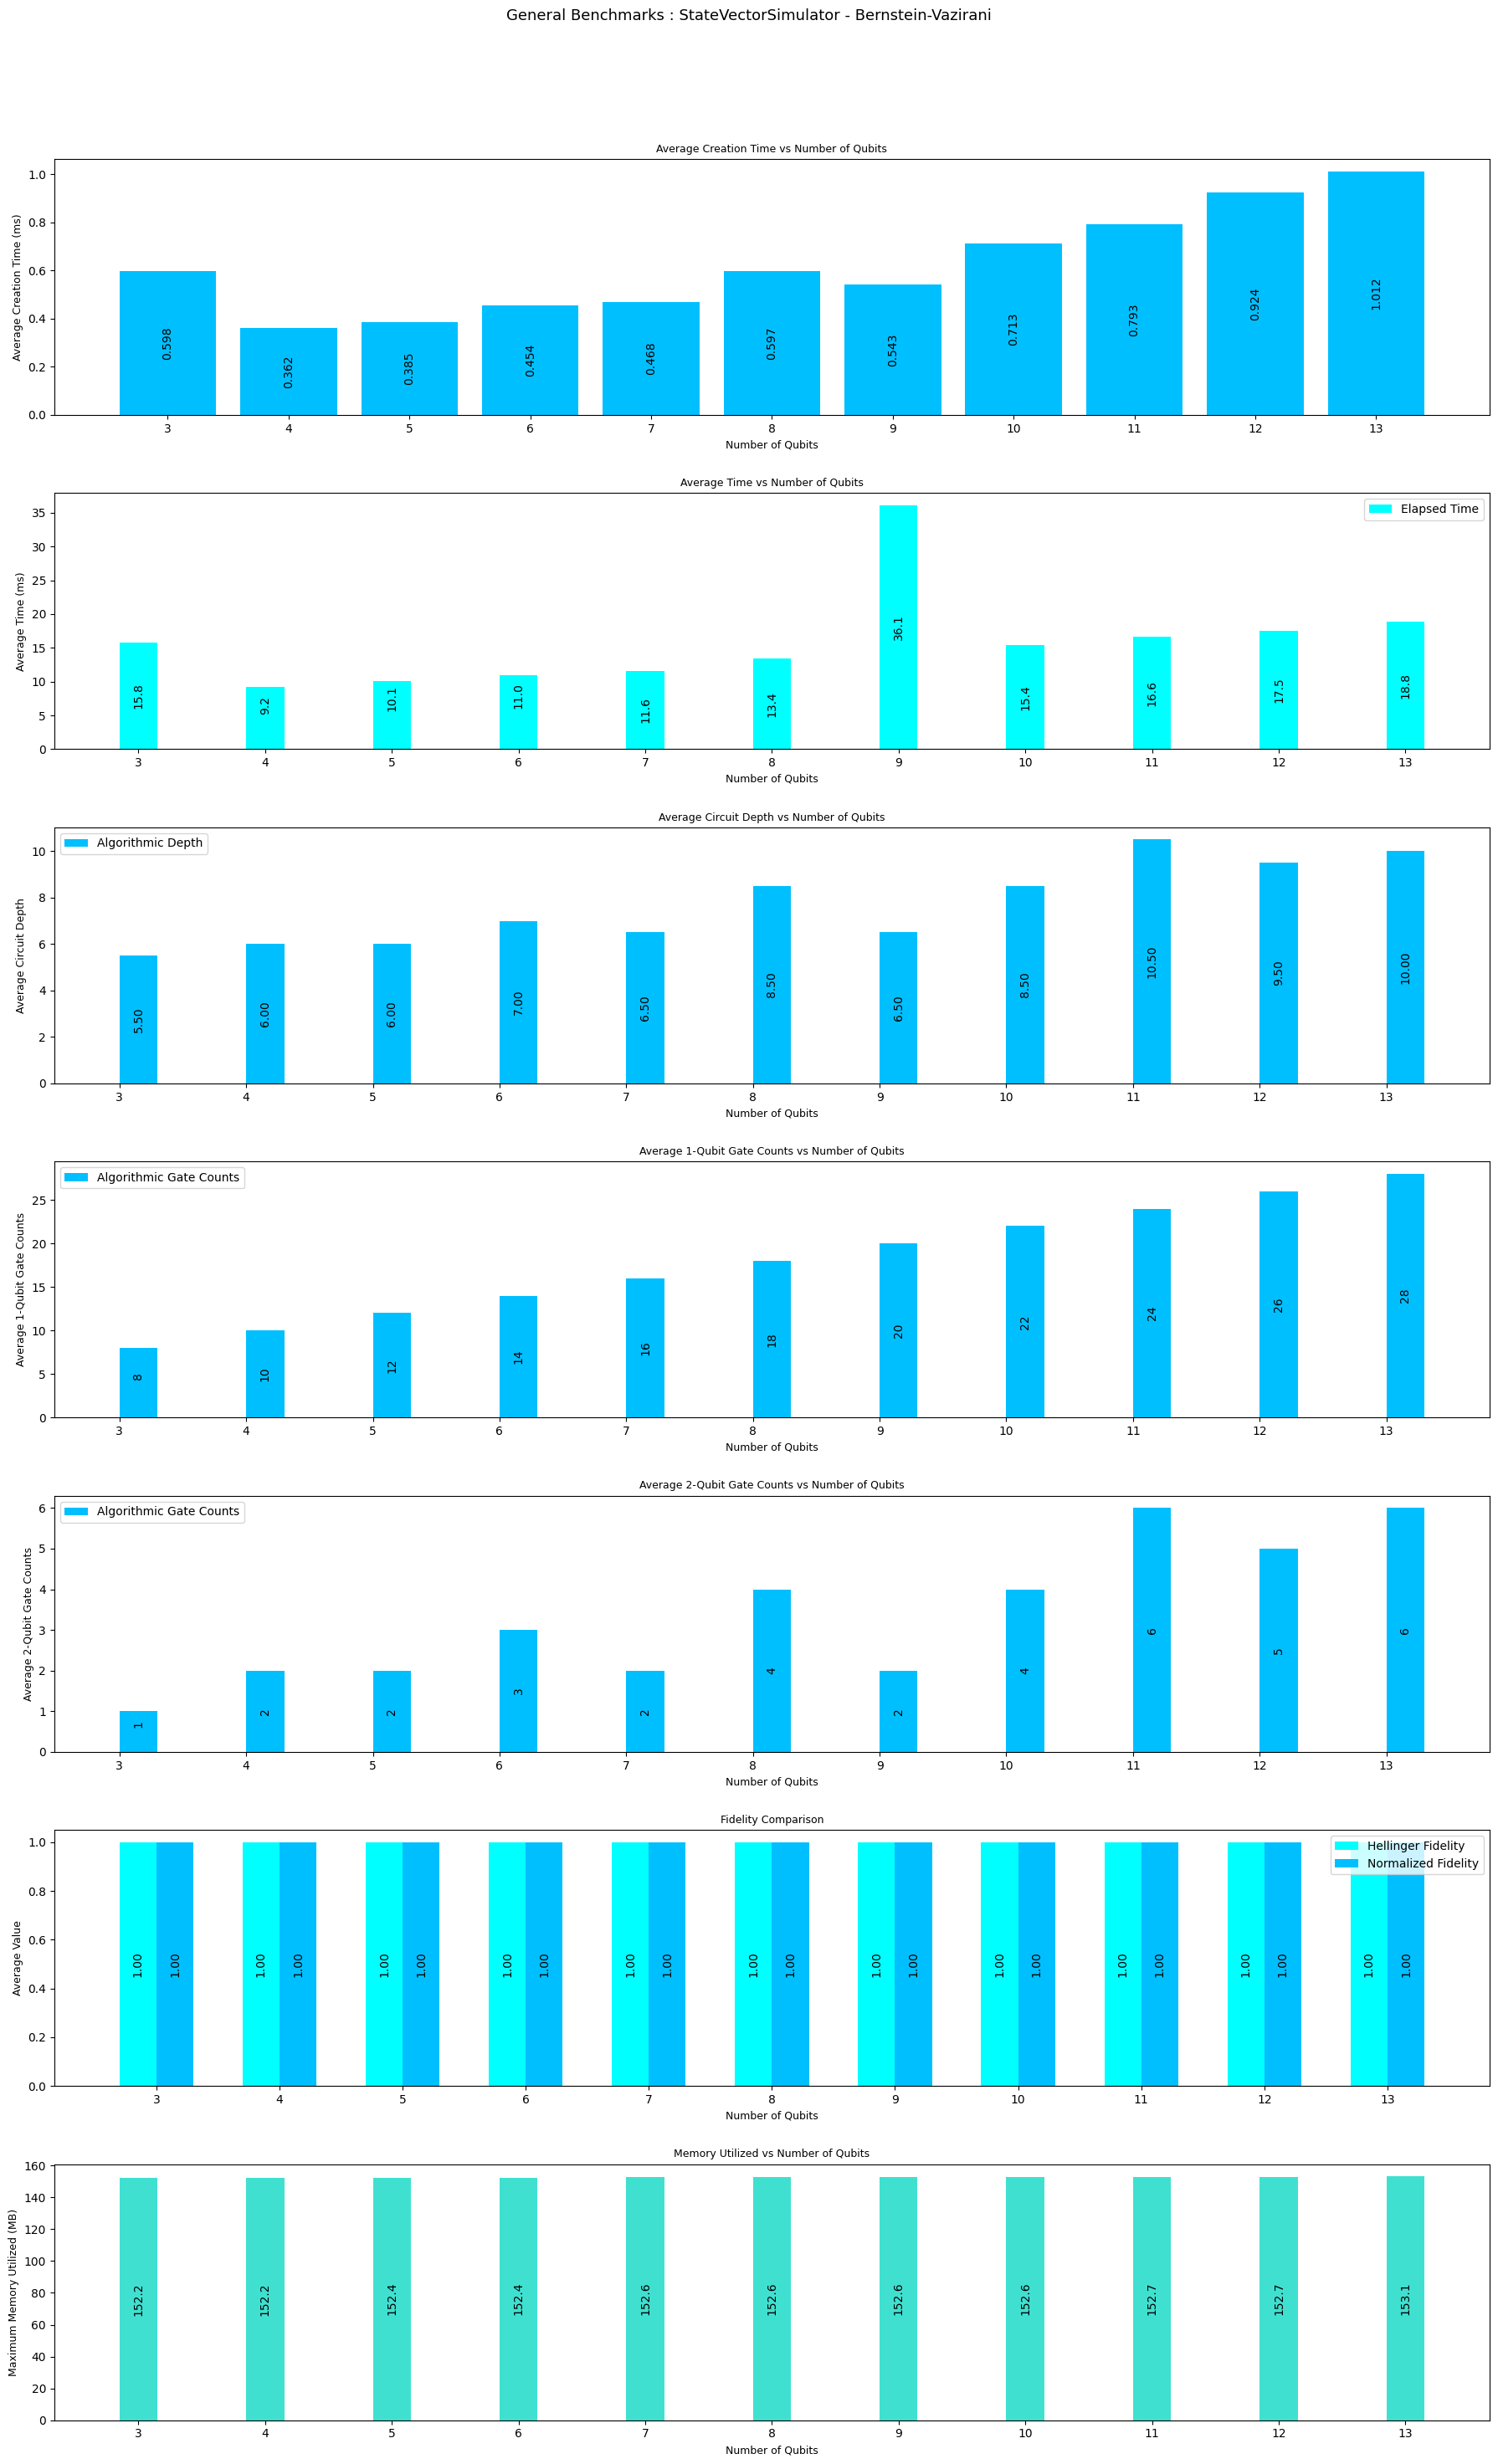

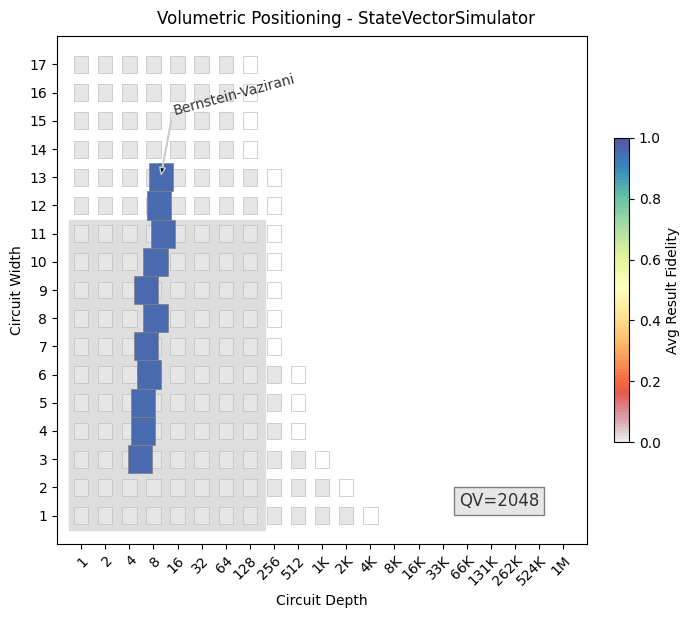

In [17]:
### Execute the benchmark program, accumulate metrics, and calculate circuit depths
(creation_times, elapsed_times, circuit_depths, fidelity_data, Hf_fidelity_data, numckts,  
algorithmic_1Q_gate_counts, algorithmic_2Q_gate_counts,mem_usage) = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = []
avg_elapsed_times = []
avg_quantum_times = []
avg_circuit_depths = []
avg_transpiled_depths = []
avg_1Q_algorithmic_gate_counts = []
avg_2Q_algorithmic_gate_counts = []
avg_1Q_Transpiled_gate_counts = []
avg_2Q_Transpiled_gate_counts = []
max_memory = []

start = 0
for num in numckts:
    avg_creation_times.append(np.mean(creation_times[start:start+num]))
    avg_elapsed_times.append(np.mean(elapsed_times[start:start+num]))
    avg_circuit_depths.append(np.mean(circuit_depths[start:start+num]))
    if gate_counts_plots == True:
        avg_1Q_algorithmic_gate_counts.append(int(np.mean(algorithmic_1Q_gate_counts[start:start+num])))
        avg_2Q_algorithmic_gate_counts.append(int(np.mean(algorithmic_2Q_gate_counts[start:start+num])))
    if Memory_utilization_plot == True:max_memory.append(np.max(mem_usage[start:start+num]))
    start += num

# Calculate the fidelity data
avg_f, avg_Hf = plot_fidelity_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")

if Store_Data:
    import json
    from datetime import datetime
    # Prepare the data dictionary
    data = {
        "configuration":{
        "min_qbits":min_qbits,
        "max_qbits":max_qbits,
        "skp_qubits":skp_qubits,
        "Type_of_Simulator":device_Name,
        "benchmark_name":benchmark_name,
        "QV_":QV_},
        "avg_creation_times": avg_creation_times,
        "avg_elapsed_times": avg_elapsed_times,
        "avg_quantum_times": avg_quantum_times,
        "avg_circuit_depths": avg_circuit_depths,
        "avg_transpiled_depths": avg_transpiled_depths,
        "avg_1Q_algorithmic_gate_counts": avg_1Q_algorithmic_gate_counts,
        "avg_2Q_algorithmic_gate_counts": avg_2Q_algorithmic_gate_counts,
        "avg_1Q_Transpiled_gate_counts": avg_1Q_Transpiled_gate_counts,
        "avg_2Q_Transpiled_gate_counts": avg_2Q_Transpiled_gate_counts,
        "max_memory": max_memory,
        "Average_fidelity":avg_f,
        "Average_Hellinger_fidelity":avg_Hf
    }
    
    # Get the current date and time
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Add the timestamp to the data
    data['last_updated'] = current_time
    
    # Define the file name
    file_name = '__data.json'
    
    # Write the data to the file
    with open(file_name, 'w') as file:
        json.dump(data, file, indent=4)
    
    print(f"***** Data has been saved to {file_name} ******")

# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits

def autolabel(rects,ax,str='{:.3f}',text_color="black"):
        max_y_value=ax.get_ylim()[1]  # Get the maximum value on the y-axis
        threshold=0.3*max_y_value   # Define threshold as 30% of max y-axis value
        for rect in rects:
            height = rect.get_height()
            if height < threshold:
                rotation = 90
                va = 'bottom'  # Place text above the bar
                xytext = (0, 3)  # Offset slightly above the bar
            else:
                rotation = 90
                va = 'center'  # Place text inside the bar
                xytext = (0, 0)  # No offset
            ax.annotate(str.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                        xytext=xytext,
                        textcoords="offset points",
                        ha='center', va=va, color=text_color, rotation=rotation)

bar_width = 0.3

# Determine the number of subplots and their arrangement
if Memory_utilization_plot and gate_counts_plots:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(18, 30))
    # Plotting for both memory utilization and gate counts
    # ax1, ax2, ax3, ax4, ax5, ax6, ax7 are available
elif Memory_utilization_plot:
    fig, (ax1, ax2, ax3, ax6, ax7) = plt.subplots(5, 1, figsize=(8, 13))
    # Plotting for memory utilization only
    # ax1, ax2, ax3, ax6, ax7 are available
elif gate_counts_plots:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(18, 30))
    # Plotting for gate counts only
    # ax1, ax2, ax3, ax4, ax5, ax6 are available
else:
    fig, (ax1, ax2, ax3, ax6) = plt.subplots(4, 1, figsize=(18, 30))
    # Default plotting
    # ax1, ax2, ax3, ax6 are available

fig.suptitle(f"General Benchmarks : {device_Name} - {benchmark_name}", fontsize=13)
for i in range(len(avg_creation_times)): #converting seconds to milli seconds by multiplying 1000
    avg_creation_times[i] *= 1000

ax1.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
x = ax1.bar(num_qubits_range, avg_creation_times, color='deepskyblue')
autolabel(ax1.patches, ax1)
ax1.set_xlabel('Number of Qubits',fontsize=9)
ax1.set_ylabel('Average Creation Time (ms)',fontsize=9)
ax1.set_title('Average Creation Time vs Number of Qubits',fontsize=9)


ax2.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))

for i in range(len(avg_elapsed_times)): #converting seconds to milli seconds by multiplying 1000
    avg_elapsed_times[i] *= 1000


Elapsed= ax2.bar(np.array(num_qubits_range), avg_elapsed_times, width=bar_width, color='cyan', label='Elapsed Time')
autolabel(Elapsed,ax2,str='{:.1f}')
ax2.set_xlabel('Number of Qubits',fontsize=9)
ax2.set_ylabel('Average Time (ms)',fontsize=9)
ax2.set_title('Average Time vs Number of Qubits',fontsize=9)
ax2.legend()


ax3.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
Algorithmic = ax3.bar(np.array(num_qubits_range) + bar_width / 2,avg_circuit_depths, color='deepskyblue', label='Algorithmic Depth', width=bar_width)  # Adjust width here
autolabel(Algorithmic,ax3,str='{:.2f}')
ax3.set_xlabel('Number of Qubits',fontsize=9)
ax3.set_ylabel('Average Circuit Depth',fontsize=9)
ax3.set_title('Average Circuit Depth vs Number of Qubits',fontsize=9)
ax3.legend()

if gate_counts_plots == True:
    ax4.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    Algorithmic_1Q_counts = ax4.bar(np.array(num_qubits_range) + bar_width / 2, avg_1Q_algorithmic_gate_counts, color='deepskyblue', label='Algorithmic Gate Counts', width=bar_width)  # Adjust width here
    autolabel(Algorithmic_1Q_counts,ax4,str='{}')
    ax4.set_xlabel('Number of Qubits',fontsize=9)
    ax4.set_ylabel('Average 1-Qubit Gate Counts',fontsize=9)
    ax4.set_title('Average 1-Qubit Gate Counts vs Number of Qubits',fontsize=9)
    ax4.legend()
    
    ax5.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    Algorithmic_2Q_counts = ax5.bar(np.array(num_qubits_range) + bar_width / 2, avg_2Q_algorithmic_gate_counts, color='deepskyblue', label='Algorithmic Gate Counts', width=bar_width)  # Adjust width here
    autolabel(Algorithmic_2Q_counts,ax5,str='{}')
    ax5.set_xlabel('Number of Qubits',fontsize=9)
    ax5.set_ylabel('Average 2-Qubit Gate Counts',fontsize=9)
    ax5.set_title('Average 2-Qubit Gate Counts vs Number of Qubits',fontsize=9)
    ax5.legend()


ax6.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
Hellinger = ax6.bar(np.array(num_qubits_range) - bar_width / 2, avg_Hf, width=bar_width, label='Hellinger Fidelity',color='cyan')  # Adjust width here
Normalized = ax6.bar(np.array(num_qubits_range) + bar_width / 2, avg_f, width=bar_width, label='Normalized Fidelity', color='deepskyblue')  # Adjust width here
autolabel(Hellinger,ax6,str='{:.2f}')
autolabel(Normalized,ax6,str='{:.2f}')
ax6.set_xlabel('Number of Qubits',fontsize=9)
ax6.set_ylabel('Average Value',fontsize=9)
ax6.set_title("Fidelity Comparison",fontsize=9)
ax6.legend()

if Memory_utilization_plot == True:
    ax7.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    x = ax7.bar(num_qubits_range, max_memory, color='turquoise', width=bar_width, label="Memory Utilizations")
    autolabel(ax7.patches, ax7,str="{:.1f}")
    ax7.set_xlabel('Number of Qubits',fontsize=9)
    ax7.set_ylabel('Maximum Memory Utilized (MB)',fontsize=9)
    ax7.set_title('Memory Utilized vs Number of Qubits',fontsize=9)


# Adjust layout to avoid overlapping
fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.5)
plt.subplots_adjust(top=0.92)
if saveplots == True:
    plt.savefig("ParameterPlotsSample.jpg")
plt.show()


# Quantum Volume Plot
Suptitle = f"Volumetric Positioning - {device_Name}"
appname=benchmark_name
if QV_ == None:
    QV=2048
else:
    QV=QV_
depth_base =2

ax = plot_volumetric_background(max_qubits=max_qbits, QV=QV,depth_base=depth_base, suptitle=Suptitle, colorbar_label="Avg Result Fidelity")

w_data = num_qubits_range
# determine width for circuit
w_max = 0
for i in range(len(w_data)):
    y = float(w_data[i])
    w_max = max(w_max, y)

d_tr_data = avg_circuit_depths
f_data = avg_f

plot_volumetric_data(ax, w_data, d_tr_data, f_data, depth_base, fill=True,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, w_max=w_max)
anno_volumetric_data(ax, depth_base,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, fill=False)